# पिटर र ब्वाँसो: यथार्थपरक वातावरण

हाम्रो अवस्थामा, पिटर लगभग थाक्न वा भोकाउन नपरी सजिलै हिँडडुल गर्न सक्थ्यो। तर, यथार्थपरक संसारमा, उसले समय-समयमा बस्न र आराम गर्नुपर्ने हुन्छ, साथै आफूलाई खाना खुवाउनुपर्ने हुन्छ। आउनुहोस्, निम्न नियमहरू लागू गरेर हाम्रो संसारलाई अझ यथार्थपरक बनाऔं:

1. एक स्थानबाट अर्को स्थानमा जाँदा, पिटरले **ऊर्जा** गुमाउँछ र केही **थकान** बढाउँछ।
2. पिटरले स्याउ खाएर थप ऊर्जा प्राप्त गर्न सक्छ।
3. पिटरले रुखमुनि वा घाँसमा आराम गरेर (अर्थात्, रुख वा घाँस भएको हरियो क्षेत्रमा हिँडेर) थकान हटाउन सक्छ।
4. पिटरले ब्वाँसो फेला पार्न र मार्नुपर्ने हुन्छ।
5. ब्वाँसो मार्नका लागि, पिटरसँग निश्चित स्तरको ऊर्जा र थकान हुनुपर्छ, अन्यथा ऊ लडाइँमा हार्छ।


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

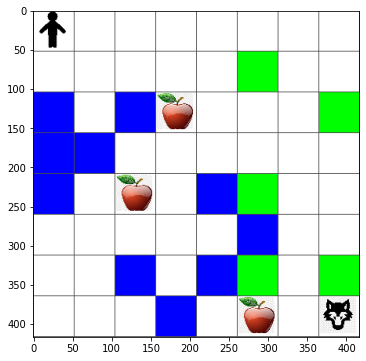

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## अवस्था परिभाषित गर्दै

हाम्रो नयाँ खेल नियमहरूमा, हामीले प्रत्येक बोर्ड अवस्थामा ऊर्जा र थकानको ट्र्याक राख्न आवश्यक छ। त्यसैले हामी `state` नामको एउटा वस्तु सिर्जना गर्नेछौं जसले वर्तमान समस्या अवस्थाको सबै आवश्यक जानकारी बोक्नेछ, जसमा बोर्डको अवस्था, ऊर्जा र थकानको वर्तमान स्तरहरू, र टर्मिनल अवस्थामा हुँदा भेडिया जित्न सकिन्छ कि सकिँदैन भन्ने कुरा समावेश हुनेछ:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## पुरस्कार कार्य

एक पुरस्कार कार्यले एजेन्टलाई कुनै कार्यको प्रदर्शनको आधारमा अंक प्रदान गर्दछ। यो कार्यले एजेन्टलाई सही दिशा तर्फ मार्गदर्शन गर्न मद्दत गर्दछ। 

### पुरस्कार कार्यको उद्देश्य
पुरस्कार कार्यको मुख्य उद्देश्य भनेको एजेन्टलाई लक्ष्य प्राप्त गर्न प्रोत्साहित गर्नु हो। यसले एजेन्टलाई सही निर्णय लिन र वातावरणसँग प्रभावकारी रूपमा अन्तरक्रिया गर्न मद्दत गर्दछ।

### पुरस्कार कार्यको संरचना
पुरस्कार कार्य सामान्यतया निम्न तत्वहरू समावेश गर्दछ:
- **इनपुट:** एजेन्टको अवस्था र कार्य
- **आउटपुट:** अंक (सकारात्मक वा नकारात्मक)

### उदाहरण
यहाँ एउटा साधारण पुरस्कार कार्यको उदाहरण छ:
@@CODE_BLOCK_1@@

यो कार्यले एजेन्टलाई लक्ष्यमा पुग्न प्रोत्साहित गर्दछ। यदि एजेन्टले सही दिशा तर्फ कदम चाल्छ भने सकारात्मक अंक प्रदान गरिन्छ। 

### [!NOTE]
पुरस्कार कार्य डिजाइन गर्दा, ध्यान दिनुहोस् कि गलत पुरस्कारले एजेन्टलाई गलत व्यवहार सिक्न प्रेरित गर्न सक्छ। 

### सामान्य सुझावहरू
- **स्पष्टता:** पुरस्कार कार्य सरल र स्पष्ट हुनुपर्छ।
- **सन्तुलन:** सकारात्मक र नकारात्मक अंकको सन्तुलन राख्नुहोस्।
- **परीक्षण:** पुरस्कार कार्यलाई विभिन्न परिदृश्यहरूमा परीक्षण गर्नुहोस्।

### [!TIP]
एजेन्टको प्रदर्शन सुधार गर्न, पुरस्कार कार्यलाई समय समयमा परिमार्जन गर्नुहोस्।


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## क्यू-लर्निङ एल्गोरिथम

वास्तविक सिक्ने एल्गोरिथम धेरै परिवर्तन हुँदैन, हामी केवल बोर्डको स्थितिको सट्टा `state` प्रयोग गर्छौं।


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

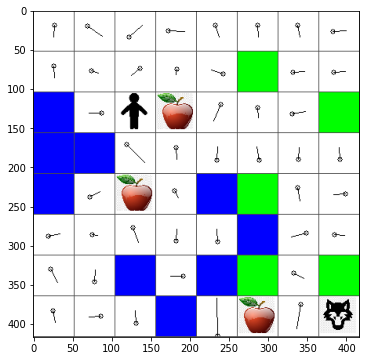

In [11]:
m.plot(Q)

## परिणामहरू

हेरौं, हामीले पिटरलाई ब्वाँसोसँग लड्न सफलतापूर्वक तालिम दिन सकेका छौं कि छैनौं!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


हामी अहिले डुब्ने घटनाहरू धेरै कम देख्छौं, तर पीटर अझै पनि सधैं भेडिया मार्न सक्षम छैन। हाइपरप्यारामिटरहरूसँग खेल्दै यो परिणाम सुधार गर्न सकिन्छ कि भनेर प्रयास गर्नुहोस्।


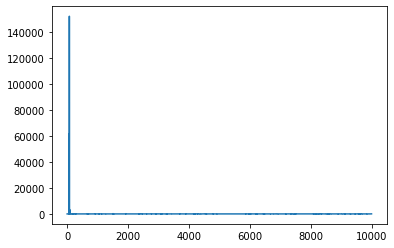

In [13]:
plt.plot(lpath)


---

**अस्वीकरण**:  
यो दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) प्रयोग गरी अनुवाद गरिएको हो। हामी यथासम्भव सटीकता सुनिश्चित गर्न प्रयास गर्छौं, तर कृपया ध्यान दिनुहोस् कि स्वचालित अनुवादहरूमा त्रुटि वा अशुद्धता हुन सक्छ। यसको मूल भाषामा रहेको मूल दस्तावेज़लाई आधिकारिक स्रोत मानिनुपर्छ। महत्त्वपूर्ण जानकारीका लागि, व्यावसायिक मानव अनुवाद सिफारिस गरिन्छ। यस अनुवादको प्रयोगबाट उत्पन्न हुने कुनै पनि गलतफहमी वा गलत व्याख्याको लागि हामी जिम्मेवार हुने छैनौं।
